# Quantile regression

### Standard regression

In this example we do quantile regression in CVXPY.
We start by discussing standard regression.
In a regression problem we are given data $(x_i,y_i)\in {\bf R}^n \times {\bf R}$, $i=1,\ldots, m$.
and fit a linear (affine) model

$$\hat y_i = \beta ^Tx_i - v,$$

where $\beta \in {\bf R}^n$ and $v \in {\bf R}$.

The residuals are $r_i = \hat y_i - y_i$.
In standard (least-squares) regression we choose $\beta,v$ to minimize $\|r\|_2^2 = \sum_i r_i^2$.
For this choice of $\beta,v$ the mean of the optimal residuals is zero.

A simple variant is to add (Tychonov) regularization, meaning we solve the optimization problem

$$\begin{array}{ll}
\mbox{minimize} & \|r\|_2^2 + \lambda \|\beta \|_2^2,
\end{array}$$

where $\lambda>0$.

### Quantile regression

An alternative to the standard least-squares penalty is the *tilted $\ell_1$ penalty*: for $\tau \in (0,1)$,

$$
\phi(u)= \tau (u)_+ + (1-\tau) (u)_- = (1/2)|u| + (\tau-1/2) u.
$$

The plots below show $\phi(u)$ for $\tau= 0.5$, $\tau= 0.1$, and $\tau= 0.9$.

![title](tilted_l1.png)

In quantile regression we choose $\beta,v$ to minimize $\sum_i \phi(r_i)$.
For $r_i \neq 0$,

$$
\frac{\partial \sum_i \phi(r_i)}{\partial v} =
\tau \left|\{i: r_i>0\} \right| - (1-\tau) \left|\{i: r_i<0\}\right|,
$$

which means that (roughly speaking) for optimal $v$ we have

$$
\tau \left|\{i: r_i>0\} \right| = (1-\tau) \left|\{i: r_i<0\}\right|.
$$

We conclude that $\tau m = \left|\{i: r_i<0\}\right|$, or the $\tau$-quantile of optimal residuals is zero.
Hence the name quantile regression.

### Example

In the following code we apply quantile regression to a time series prediction problem.
We fit the time series $x_t$, $t=0,1,2, \ldots$ with an auto-regressive (AR) predictor


$$\hat x_{t+1} = \beta^T (x_t,\ldots, x_{t-M})- v,$$

where $M=10$ is the memory of predictor.

We use quantile regression for $\tau = 0.1,0.5, 0.9$ to fit three AR models.
At each time $t$, the models give three one-step-ahead predictions:

$$
\hat x_{t+1} ^{0.1}, \qquad
\hat x_{t+1} ^{0.5}, \qquad
\hat x_{t+1} ^{0.9}
$$

We divide the time series into a training set, which we use to fit the AR models, and a test set.
We plot $x_t$ and the predictions
$\hat x_{t+1} ^{0.1}$,
$\hat x_{t+1} ^{0.5}$,
$\hat x_{t+1} ^{0.9}$
for the training set and the test set.

In [1]:
# Generate data for quantile regression.
import numpy as np

np.random.seed(1)
TRAIN_LEN = 400
SKIP_LEN = 100
TEST_LEN = 50
TOTAL_LEN = TRAIN_LEN + SKIP_LEN + TEST_LEN
m = 10
x0 = np.random.randn(m)
x = np.zeros(TOTAL_LEN)
x[:m] = x0
for i in range(m + 1, TOTAL_LEN):
    x[i] = 1.8 * x[i - 1] - 0.82 * x[i - 2] + np.random.normal()

x = np.exp(0.05 * x + 0.05 * np.random.normal(size=TOTAL_LEN))

In [2]:
# Form the quantile regression problem.
import cvxpy as cp


w = cp.Variable(m + 1)
v = cp.Variable()
tau = cp.Parameter()
error = 0
for i in range(SKIP_LEN, TRAIN_LEN + SKIP_LEN):
    r = x[i] - (w.T @ x[i - m - 1 : i] + v)
    error += 0.5 * cp.abs(r) + (tau - 0.5) * r
prob = cp.Problem(cp.Minimize(error))

In [3]:
# Solve quantile regression for different values of tau.
tau_vals = [0.9, 0.5, 0.1]
pred = np.zeros((len(tau_vals), TOTAL_LEN))
r_vals = np.zeros((len(tau_vals), TOTAL_LEN))
for k, tau_val in enumerate(tau_vals):
    tau.value = tau_val
    prob.solve()
    pred[k, :m] = x0
    for i in range(SKIP_LEN, TOTAL_LEN):
        pred[k, i] = (x[i - m - 1 : i].T @ w + v).value
        r_vals[k, i] = (x[i] - (x[i - m - 1 : i].T @ w + v)).value

Below we plot the full time series, the training data with the three AR models, and the test data with the three AR models.

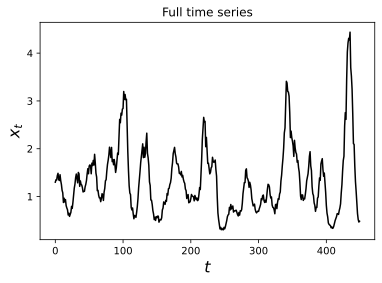

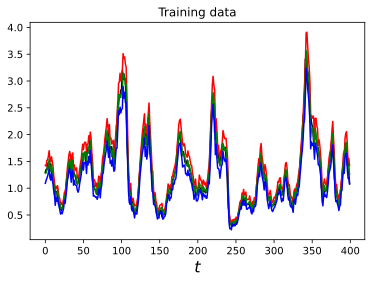

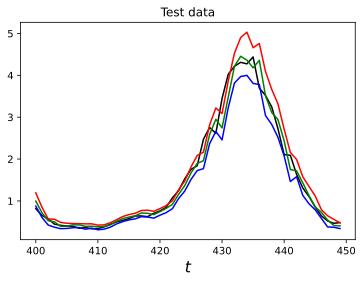

In [4]:
# Generate plots.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

# Plot the full time series.
plt.plot(range(0, TRAIN_LEN + TEST_LEN), x[SKIP_LEN:], "black", label=r"$x$")
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$x_t$", fontsize=16)
plt.title("Full time series")
plt.show()

# Plot the predictions from the quantile regression on the training data.
plt.plot(range(0, TRAIN_LEN), x[SKIP_LEN:-TEST_LEN], "black", label=r"$x$")
colors = ["r", "g", "b"]
for k, tau_val in enumerate(tau_vals):
    plt.plot(
        range(0, TRAIN_LEN),
        pred[k, SKIP_LEN:-TEST_LEN],
        colors[k],
        label=r"$\tau = %.1f$" % tau_val,
    )
plt.xlabel(r"$t$", fontsize=16)
plt.title("Training data")
plt.show()

# Plot the predictions from the quantile regression on the test data.
plt.plot(range(TRAIN_LEN, TRAIN_LEN + TEST_LEN), x[-TEST_LEN:], "black", label=r"$x$")
for k, tau_val in enumerate(tau_vals):
    plt.plot(
        range(TRAIN_LEN, TRAIN_LEN + TEST_LEN),
        pred[k, -TEST_LEN:],
        colors[k],
        label=r"$\tau = %.1f$" % tau_val,
    )
plt.xlabel(r"$t$", fontsize=16)
plt.title("Test data")
plt.show()

Below we plot the empirical CDFs of the residuals for the three AR models on the training data and the test data.
Notice that $\tau$-quantile of the optimal residuals is close to zero.

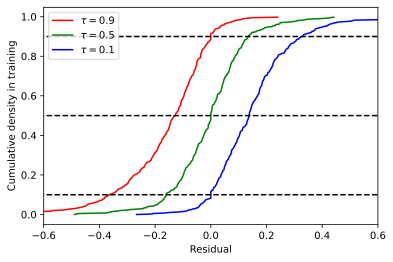

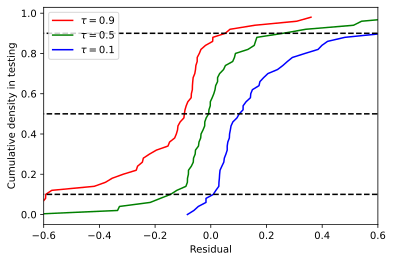

In [5]:
# Plot the empirical CDFs of the residuals.

# Plot the CDF for the training data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted = np.sort(r_vals[k, SKIP_LEN : SKIP_LEN + TRAIN_LEN])
    yvals = np.arange(len(sorted)) / float(len(sorted))
    plt.plot(sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1.0, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x) * [val], "k--")
plt.xlabel("Residual")
plt.ylabel("Cumulative density in training")
plt.xlim([-0.6, 0.6])
plt.legend(loc="upper left")
plt.show()

# Plot the CDF for the testing data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted = np.sort(r_vals[k, -TEST_LEN:])
    yvals = np.arange(len(sorted)) / float(len(sorted))
    plt.plot(sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x) * [val], "k--")
plt.xlabel("Residual")
plt.ylabel("Cumulative density in testing")
plt.xlim([-0.6, 0.6])
plt.legend(loc="upper left")
plt.show()